In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from Vis import plot_loss, plot_roc
from Preprocessing import Preprocessing
from Preprocessing import Cols
import numpy as np
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from pandas import DataFrame
from pandas import Series
import pandas as pd
from keras.layers import Dropout
from sklearn.preprocessing import OneHotEncoder
import numpy as np

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# pandas.set_option('max_columns',10)

In [2]:
pre = Preprocessing()
X, y = pre.load_data(time_gap=300)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


In [3]:
per_action_dataset = pre.per_action_dataset
per_action_dataset.index = per_action_dataset.ITEST_id
per_action_dataset = per_action_dataset.drop(['ITEST_id', 'assistmentId', 'problemId', 'assignmentId', 'actionId'], axis=1)

In [4]:
# defining sequence length (or number of time-steps) for each student and batch-size
max_length_seq = 1000

In [5]:
# show the seq of a sample student (id =9)
#per_action_dataset[per_action_dataset.index.get_level_values(0) ==9].head()
per_action_dataset.to_csv("Debug/1-per_action_dataset.csv")

In [6]:
#truncating seq of each student and only considering his last 500 actions based on startTime feature
truncated_input = per_action_dataset.sort_values("startTime",ascending=False).groupby('ITEST_id').head(max_length_seq)
truncated_input.to_csv("Debug/2-truncated_input.csv")

In [7]:
# data = []
# py.sign_in('fnozarian', 'FtJBu0EnwcpKsha1Tu1F')
# for col in truncated_input.columns:
#     data.append(  go.Box( y=truncated_input[col], name=col, showlegend=False ) )
# py.image.save_as(data, filename='a-simple-plot.png')

In [8]:
# scaling dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(truncated_input)
X_scaled = DataFrame(X_scaled, index=truncated_input.index, columns=truncated_input.columns)
#X_scaled[X_scaled.index.get_level_values(0) ==9].head()
X_scaled.to_csv("Debug/2-X_scaled.csv")

In [9]:
fig, ax = plt.subplots()  # create figure & 1 axis
X_scaled.boxplot(X_scaled.columns.difference(["startTime", 'endTime']).values.tolist(),ax=ax)
fig.set_size_inches(100,100)
fig.savefig('X_scaled.png')   # save the figure to file
plt.close(fig) 

In [10]:
batch_size=1

In [11]:
# padding sequences to have a same length
X_padded = []
for stud_id, stud_seq in X_scaled.groupby('ITEST_id'):
    X_padded.append(stud_seq)
X_padded = sequence.pad_sequences(X_padded, max_length_seq, dtype='float64', padding="post", truncating="post", value=9999)

In [12]:
pd.set_option('max_columns',90)
# getting a sense about padded dataset
new_seq_ix = pd.Index(list(range(0,max_length_seq))* X_padded.shape[0], name="seq_ix")
ITEST_ix = pd.Index(np.repeat(sorted(X_scaled.index.get_level_values(0).unique()), max_length_seq), name='ITEST_id')
paddedData = DataFrame(X_padded.reshape(X_padded.shape[0]*X_padded.shape[1], -1), index=[ITEST_ix, new_seq_ix], columns=X_scaled.columns)
paddedData.to_csv("Debug/3-paddedData.csv")

In [13]:
# creating label dataset with index as ITEST_id values
label_dataset = pre.label_dataset[['ITEST_id', 'isSTEM']]
label_dataset.index = label_dataset.ITEST_id
label_dataset = label_dataset.drop("ITEST_id", axis = 1)
#label_dataset

In [14]:
# join label with dataset to make sure we have a consistent dataset
# (of course before the training the label column will be droped from data)
X_with_label = paddedData.join(label_dataset)
#print(X_with_label.shape)
X_with_label.to_csv("Debug/4-X_with_label.csv")

In [15]:
from sklearn.utils import resample

df_majority = X_with_label[X_with_label['isSTEM'] == 0]
df_minority = X_with_label[X_with_label['isSTEM'] == 1]

minority_len = len(df_minority.index.get_level_values(0).unique())
majority_len = len(df_majority.index.get_level_values(0).unique())

sampled_df_majority = df_majority.loc[resample(df_majority.index.get_level_values(0).unique(), n_samples=minority_len, replace=False).values]

balanced_X = pd.concat([df_minority, sampled_df_majority])

balanced_X[balanced_X.index.get_level_values(0) == 27].to_csv("5-balanced_X_stud27.csv")

In [17]:
y_prepared = balanced_X.groupby("ITEST_id").isSTEM.first().values
X_prepared = balanced_X.drop("isSTEM", axis=1)
X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[2])) ### WTF :| shape[1]!!! or shape[2]???
#print(X_prepared.shape)
#X_prepared
# X_prepared[X_prepared.index.get_level_values(0) == 27].to_csv("6-X_prepared_stud27.csv")

## Model

In [18]:
from keras.layers import Masking

def create_LSTM_model(max_length_seq, feature_size):
    # create the LSTM network
    model = Sequential()
    model.add(Masking(mask_value=9999, input_shape=(max_length_seq, feature_size) ))
    model.add(LSTM(200, return_sequences=True))
    model.add(LSTM(200))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
X_train.shape

(231, 1000, 47)

In [19]:
# splitting train/test data 
X_train, X_test, y_train,y_test = train_test_split(X_prepared,y_prepared, train_size=.99)
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()

In [20]:
# Create model
model = create_LSTM_model(max_length_seq, X_train.shape[2])
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.33)

Train on 154 samples, validate on 77 samples
Epoch 1/20
154/154 [==============================] - 78s - loss: 0.7337 - acc: 0.5130 - val_loss: 0.7133 - val_acc: 0.4805
Epoch 2/20
154/154 [==============================] - 75s - loss: 0.6494 - acc: 0.6039 - val_loss: 0.8483 - val_acc: 0.4026
Epoch 3/20
154/154 [==============================] - 76s - loss: 0.6090 - acc: 0.7078 - val_loss: 0.8387 - val_acc: 0.4416
Epoch 4/20
154/154 [==============================] - 76s - loss: 0.5737 - acc: 0.6818 - val_loss: 0.9083 - val_acc: 0.4805
Epoch 5/20
154/154 [==============================] - 76s - loss: 0.5242 - acc: 0.7597 - val_loss: 0.9967 - val_acc: 0.3896
Epoch 6/20
154/154 [==============================] - 76s - loss: 0.4678 - acc: 0.7792 - val_loss: 1.0801 - val_acc: 0.4286
Epoch 7/20
154/154 [==============================] - 76s - loss: 0.4007 - acc: 0.7792 - val_loss: 1.2232 - val_acc: 0.4545
Epoch 8/20
154/154 [==============================] - 76s - loss: 0.2850 - acc: 0.8766 

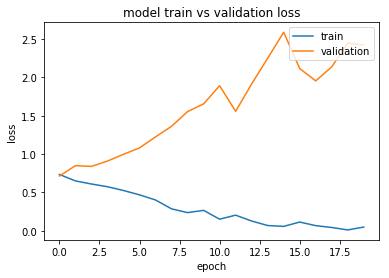

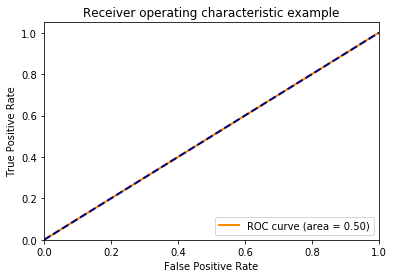

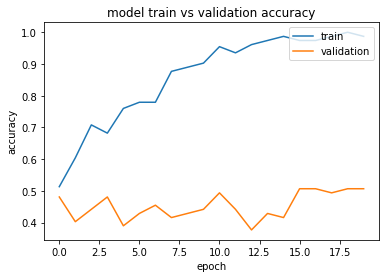

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 1000, 47)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 200)         198400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 519,602
Trainable params: 519,602
Non-trainable params: 0
_________________________________________________________________
None
Test ROC Score: 1.000000
Test RMSE Score: 0.514021
Final Competition Score: 1.485979


In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from Vis import plot_accuracy
# do prediction
y_pred = model.predict(X_test, batch_size=batch_size)

# calculating scores
roc_score = roc_auc_score(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)

#printing and plotting model and score information
plot_loss(history)
plot_roc(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
plot_accuracy(history)

print(model.summary())
print("Test ROC Score: %f" % roc_score)
print("Test RMSE Score: %f" % sqrt(mse_score))
print("Final Competition Score: %f" % (1 - sqrt(mse_score) + roc_score))